Status do Fit = ****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      5.76406
NDf                       =            0
Edm                       =  2.22832e-07
NCalls                    =           79
frac0                     =    0.0170633   +/-   0.833639     	 (limited)
frac1                     =     0.982198   +/-   0.792977     	 (limited)


✅ Resultado do Fit:
Sinal = 0.0171 ± 0.8336
Background = 0.9822 ± 0.7930
Minuit2Minimizer: Minimize with max-calls 1220 convergence for edm < 0.01 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 5.76406487066455409
Edm   = 2.22832383449036259e-07
Nfcn  = 79
frac0	  = 0.0170633	 +/-  0.833639	(limited)
frac1	  = 0.982198	 +/-  0.792977	(limited)


Warning in <TROOT::Append>: Replacing existing TH1: h_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_background (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


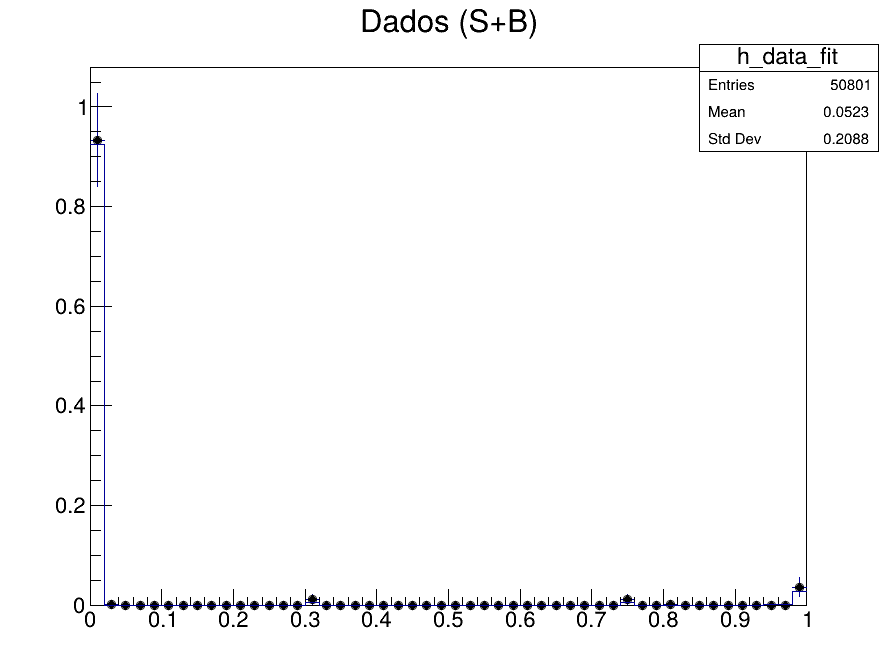

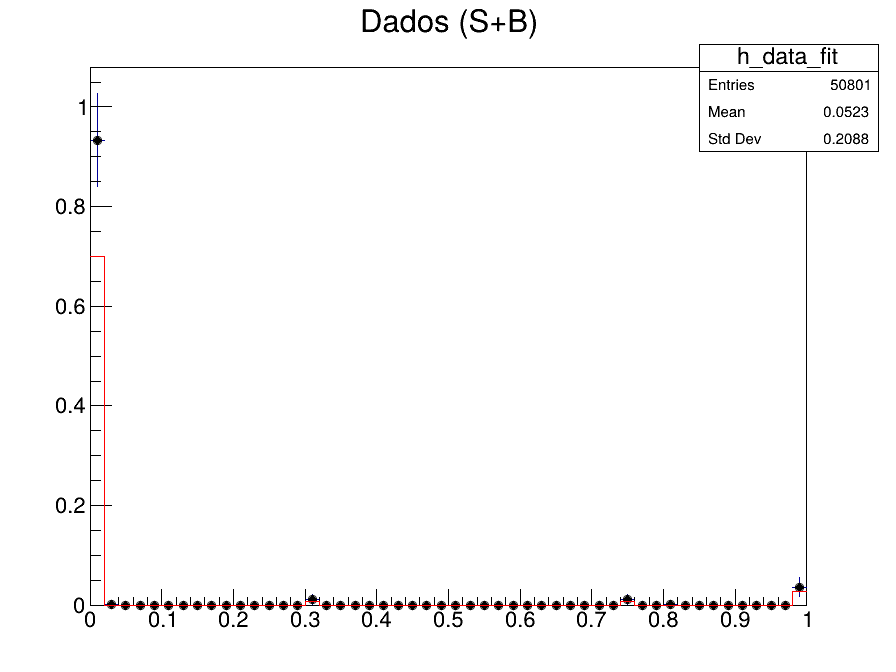

In [4]:
import ROOT
import pandas as pd
import ctypes

# ======================================================
# Carregar arquivo ÚNICO que contém sinal e background
# ======================================================
data_df = pd.read_csv("/home/lphelipe/Cuts_code/Shape_analysis/divisao_dados/scores_arquivo1_v1.csv")

# Separar usando label (1 = sinal, 0 = background)
signal_df = data_df[data_df['label'] == 1]
background_df = data_df[data_df['label'] == 0]

# ======================================================
# Criar histogramas
# ======================================================
bins = 50
ROOT.TH1.SetDefaultSumw2(True)

h_signal = ROOT.TH1F("h_signal", "Sinal", bins, 0.0, 1.0)
h_background = ROOT.TH1F("h_background", "Background", bins, 0.0, 1.0)
h_data = ROOT.TH1F("h_data", "Dados (S+B)", bins, 0.0, 1.0)

for s, w in zip(signal_df['score'], signal_df['weight']):
    h_signal.Fill(s, w)

for s, w in zip(background_df['score'], background_df['weight']):
    h_background.Fill(s, w)

# Dados reais = soma direta dos dois
h_data.Add(h_signal)
h_data.Add(h_background)

# Guardar total para depois escalar a previsão
total_data_events = h_data.Integral()

# ======================================================
# Criar histogramas normalizados para o FIT
# ======================================================
h_signal_fit = h_signal.Clone("h_signal_fit")
h_background_fit = h_background.Clone("h_background_fit")
h_data_fit = h_data.Clone("h_data_fit")

h_signal_fit.Scale(1.0 / h_signal_fit.Integral())
h_background_fit.Scale(1.0 / h_background_fit.Integral())
h_data_fit.Scale(1.0 / h_data_fit.Integral())

# ======================================================
# TFractionFitter
# ======================================================
mc = ROOT.TObjArray()
mc.Add(h_signal_fit)
mc.Add(h_background_fit)

fitter = ROOT.TFractionFitter(h_data_fit, mc)
fitter.Constrain(0, 0.0, 1.0)
fitter.Constrain(1, 0.0, 1.0)

status = fitter.Fit()
print("Status do Fit =", status)

# Frações obtidas
val_s = ctypes.c_double(0)
err_s = ctypes.c_double(0)
val_b = ctypes.c_double(0)
err_b = ctypes.c_double(0)
fitter.GetResult(0, val_s, err_s)
fitter.GetResult(1, val_b, err_b)

print(f"\n✅ Resultado do Fit:")
print(f"Sinal = {val_s.value:.4f} ± {err_s.value:.4f}")
print(f"Background = {val_b.value:.4f} ± {err_b.value:.4f}")

# Plot do fit
result = fitter.GetPlot()

c1 = ROOT.TCanvas("c1", "TFractionFitter", 900, 700)
h_data_fit.Draw("E")
result.Draw("hist same")
c1.Draw()

# ======================================================
# ✅ AGORA: Controle manual da fração (usando alpha)
# ======================================================
alpha = 0.25  # <-- ajuste aqui a fração de sinal manualmente

# Combinação linear correta
h_manual = h_signal_fit.Clone("h_manual")
h_manual.Reset()
#h_manual.Scale(alpha)
h_manual.Add(h_manual, h_background_fit, alpha, 1 - alpha)
#h_manual.Add(h_background_fit, 1 - alpha)

# Plot da combinação manual
c2 = ROOT.TCanvas("c2", f"Proporcao manual (alpha={alpha})", 900, 700)
h_manual.SetLineColor(ROOT.kRed)
h_data_fit.SetMarkerStyle(20)
h_data_fit.Draw("E")
h_manual.Draw("hist same")
c2.Draw()
